# Description

This notebook is intended to test FEM capabilities using libigl bound to python.

# Load libraries

In [19]:
import igl
import scipy as sp
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt

# Initial parameters

## Initial mesh

In [3]:
# Read pig and retrieve shape
v, f = igl.read_triangle_mesh("meshes/oloid64_tri.obj")
print("===== Characteristics of the mesh =====")
print("Number of vertices: {}".format(v.shape[0]))
print("Number of faces: {}".format(f.shape[0]))

# Visualize pig
mp.plot(v, f)

===== Characteristics of the mesh =====
Number of vertices: 66
Number of faces: 128


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.5,…

## Boundary constraints

# Basis functions

## Definition

In [27]:
print((1000 *(1000/np.sqrt(2) + 1/np.sqrt(2)) - 1e6) / 1e6)
print(1 *(1000/np.sqrt(101) + 10*1/np.sqrt(101)) - 1)

-0.29218611203226597
99.4987562112089


In [63]:
a = np.arange(9).reshape(3, 3)
print(a)
print(a[[1, 2, 0], :])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[3 4 5]
 [6 7 8]
 [0 1 2]]


In [105]:
def inTriangle(X, Xtri):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtri : position of the triangle's vertices, row by row
    
    Output:
    - isInside : whether the point belongs to the triangle or not
    '''
    abg = np.linalg.solve(Xtri.T, X)
    isInside = (abs(np.sum(abg) - 1) < 1e-9) and (0. <= abg <= 1.)
    return isInside

def inTet(X, Xtet):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtet : position of the tetrahedron's vertices, row by row
    
    Output:
    - isInside : whether the point is inside the tet or not
    '''
    abg = np.linalg.solve(Xtet[:3, :] - Xtet[3, :], X - Xtet[3, :])
    isInside = (np.sum(abg) <= 1) and (0. <= abg <= 1.)
    return isInside

def basisEval(v, f, X, v_id, f_id):
    # Permute indices so that the first 
    nPerm   = np.argwhere(f[f_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%f.shape[1] for i in range(f.shape[1])]
    
    # Select with permutation
    Xtri    = v[f[f_id]][idxPerm, :]
    
    # Compute gradients
    dirOrt  = (Xtri[1, :] - Xtri[2, :]) / np.linalg.norm(Xtri[1, :] - Xtri[2, :])
    gradDir = (Xtri[0, :] - Xtri[1, :]) - dirOrt @ (Xtri[0, :] - Xtri[1, :]) * dirOrt
    grad    = gradDir / (gradDir @ (Xtri[0, :] - Xtri[1, :]) + 1e-5)
    
    # Compute value:
    val = grad @ (X - Xtri[1, :])
    
    return val

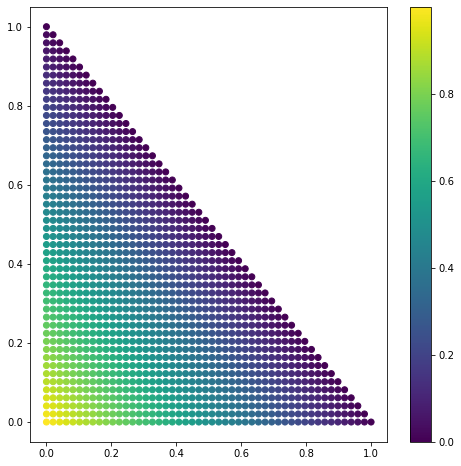

In [109]:
testV = np.array([[0., 0., 0.],
                  [0., 1., 0.],
                  [1., 0., 0.]])

testF = np.array([[0, 1, 2]])

# Barycentric coordinates
as_, bs_ = np.linspace(0, 1), np.linspace(0, 1)

abgs = []
for a in as_:
    for b in bs_:
        g = 1. - a - b
        if g >= 0:
            abgs.append([a, b, g])
                
ABGs = np.array(abgs)

# Points coordinates
pointsPlot = ABGs @ testV[testF[0]]

# Compute basis function value
vals = np.zeros(shape=pointsPlot.shape[0])
for i, point in enumerate(pointsPlot):
    vals[i] = basisEval(testV, testF, point, 0, 0)

plt.figure(figsize=(8, 8))
sc = plt.scatter(pointsPlot[:, 0], pointsPlot[:, 1], c=vals)
plt.colorbar(sc)
plt.show()

## Gradients

# Assemble matrices

## Stiffness

## Mass matrix